# A/B Testing on Facebook Ad Campaigns

## Overview
This project investigates the effectiveness of three different Facebook ad campaigns conducted by an anonymous organization in 2017. By leveraging A/B testing, the analysis aims to determine if the observed differences in conversion rates across these campaigns are statistically significant and attributable to the campaigns themselves rather than random variation. Here, we aims to analyze the effectiveness of ad campaigns using key performance indicators (KPIs) like conversion rates. The goal is to determine whether differences in campaign performance are statistically significant, suggesting true causality.

### Objective and Hypothesis
**Objective:** Assess and compare the performance of three different ad campaigns on Facebook.  
**Hypothesis:** There is a statistically significant difference in conversion rates between the campaigns.

### Data Source
The dataset is sourced from Kaggle's “Sales Conversion Optimization” by Hakan Kenshin.

## Data Preprocessing

In [1]:

# Importing necessary libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.impute import KNNImputer
from scipy.stats import shapiro, levene, mannwhitneyu

In [4]:
# Loading the dataset
df = pd.read_csv('KAG_conversion_data.csv')
df

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710001,8,2


In [3]:
# Data overview
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
mean,9.872611e+05,1067.382327,133783.989501,32.766404,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,1.939928e+05,121.629393,20500.308622,26.952131,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,7.087460e+05,916.000000,103916.000000,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,7.776325e+05,936.000000,115716.000000,16.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,1.121185e+06,1178.000000,144549.000000,25.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,1.121804e+06,1178.000000,144657.500000,31.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000
max,1.314415e+06,1178.000000,179982.000000,114.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000


### Data Description
The dataset contains 1,143 entries and 11 columns, including:
- `ad_id`: Unique ID for each ad.
- `xyz_campaign_id`: ID associated with each ad campaign of XYZ company.
- `fb_campaign_id`: ID associated with how Facebook tracks each campaign.
- `age`: Age of the person to whom the ad is shown.
- `gender`: Gender of the person to whom the ad is shown.
- `interest`: A code specifying the category to which the person’s interest belongs.
- `Impressions`: Number of times the ad was shown.
- `Clicks`: Number of clicks on the ad.
- `Spent`: Amount paid by the company to Facebook to show the ad.
- `Total_Conversion`: Number of people who inquired about the product after seeing the ad.
- `Approved_Conversion`: Number of people who bought the product after seeing the ad.

The columns all have no null or invalid type values. Moreover, from observing the quantiles, max and min values, there are no clear sign of outliers presented in the data.

### Data Cleaning
It is easy to notice that some of entries are errorneous, containing 0 values in Clicks, while the other columns such as Total_Conversion whave non-zero values. This is illogical because an ad cannot still gain postive conversions (customers) while no one clicks on it.

In [5]:
print("The number of 0-values in Clicks (given that Conversion are non-zero):", len(df[(df["Clicks"] == 0) & (df["Total_Conversion"] != 0)]))

The number of 0-values in Clicks (given that Conversion are non-zero): 204


To perform imputation for the invalid values in Clicks, we can use the K-Nearest Neighbors (KNN) algorithm from sklearn. The algorithm will attempt to predict the true value of an entry in reference to the mean of its neighbors, which partially negates the probability of generating biased values.

In [6]:
# Handling erroneous data where Clicks is 0 but Total_Conversion is non-zero
df["Clicks"].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=["gender", "age"])))

df["Clicks"] = df_imputed[5]


In [10]:
print("The number of 0-values in Clicks (given that Conversion are non-zero):", len(df[(df["Clicks"] == 0) & (df["Total_Conversion"] != 0)]))

The number of 0-values in Clicks (given that Conversion are non-zero): 0


Redundancy Identification: The project has identified that the columns ad_id and fb_campaign_id are redundant. This means that these columns are not necessary for the analysis because their information can be sufficiently captured by another column, xyz_campaign_id. The xyz_campaign_id is considered enough to categorize the advertising campaigns, and therefore, the additional columns (ad_id and fb_campaign_id) don't add any new or useful information. To simplify the dataset and avoid unnecessary complexity, these redundant columns will be dropped.  
The interest column is mentioned as contributing little information to the analysis. Therefore, it is also considered for removal.  
Categorical Conversion: The xyz_campaign_id is currently in numerical form. If left as a numerical data type, Python might treat it as a continuous variable. To ensure that the data is handled appropriately during analysis, Since xyz_campaign_id represents categories, it makes sense to convert this column to a categorical data type.

In [7]:
# Dropping redundant columns
df = df.drop(columns=["ad_id", "fb_campaign_id", "interest"])

# Categorical Conversion
df["xyz_campaign_id"] = df["xyz_campaign_id"].astype('object', copy=False)

### Additional feature engineering
Using the features given in the data set, we can also perform feature engineering to generate some KPIs that are important for later analysis:

Conversion rate (CR). The rate of user who enquired the product after viewing the ad. This helps to measure the the percentage of users that actually become interested and bought the product being motivated by viewing the ad in a marketing campaign.  
Click-through rate (CTR). The ratio of clicks from impressions of each ad. In other words, CTR is the percentage of users that click on the ad among those who have seen the ad. This metric measures how engaging and relevant are the ads to the targetted audience.  
Cost per click (CPC). The cost of gaining a click in each ad. This metric can help evaluate whether the spending on aquiring one additional user to pay attention to the ad is cost-efficient or not.

In [58]:
# Calculating CR, CTR, CPC

df["CR"] = df["Total_Conversion"] / df["Impressions"]

df["CTR"] = df["Clicks"] / df["Impressions"]

df["CPC"] = df["Spent"] / df["Clicks"]

In [9]:
df.head(5)

,xyz_campaign_id,age,gender,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CR,CTR,CPC
0,916,30-34,M,7350,1.0,1.43,2,1,0.000272,0.000136,1.43
1,916,30-34,M,17861,2.0,1.82,2,0,0.000112,0.000112,0.91
2,916,30-34,M,693,1.0,0.00,1,0,0.001443,0.001443,0.00
3,916,30-34,M,4259,1.0,1.25,1,0,0.000235,0.000235,1.25
4,916,30-34,M,4133,1.0,1.29,1,1,0.000242,0.000242,1.29


now, we will convert age and gender columns as numerical variable.

In [11]:
# Look for unique values in 'age' column
print("Unique values in 'age' column:", df["age"].unique())

Unique values in 'age' column: ['30-34' '35-39' '40-44' '45-49']


In [12]:
# Replace character string age ranges with numbers
age_map = {'30-34': 32, '35-39': 37, '40-44': 42, '45-49': 47}
df['age'] = df['age'].map(age_map)

In [13]:
# Convert age variable to integer
df['age'] = df['age'].astype(int)

In [14]:
# Check that age variable is now numeric
print("Unique values in 'age' after conversion:", df['age'].unique())
print("Data type of 'age':", df['age'].dtype)

Unique values in 'age' after conversion: [32 37 42 47]
Data type of 'age': int32


In [15]:
# Convert gender variable to integer
gender_map = {'M': 0, 'F': 1}
df['gender'] = df['gender'].map(gender_map)

In [16]:
# Check that gender variable is now numeric.

df['gender'].dtype

dtype('int64')

## Exploratory Data Analysis (EDA)

Before going in the details of the efficiency of each ad campaign, let us familiarize ourselves with the data by performing exploratory analysis of the features.

In [17]:
print("Number of Companies for campaign : ",len(df['xyz_campaign_id'].unique()))

Number of Companies for campaign :  3


### Univariate Analysis: Histograms for key features

(0.0, 1.0, 0.0, 1.0)

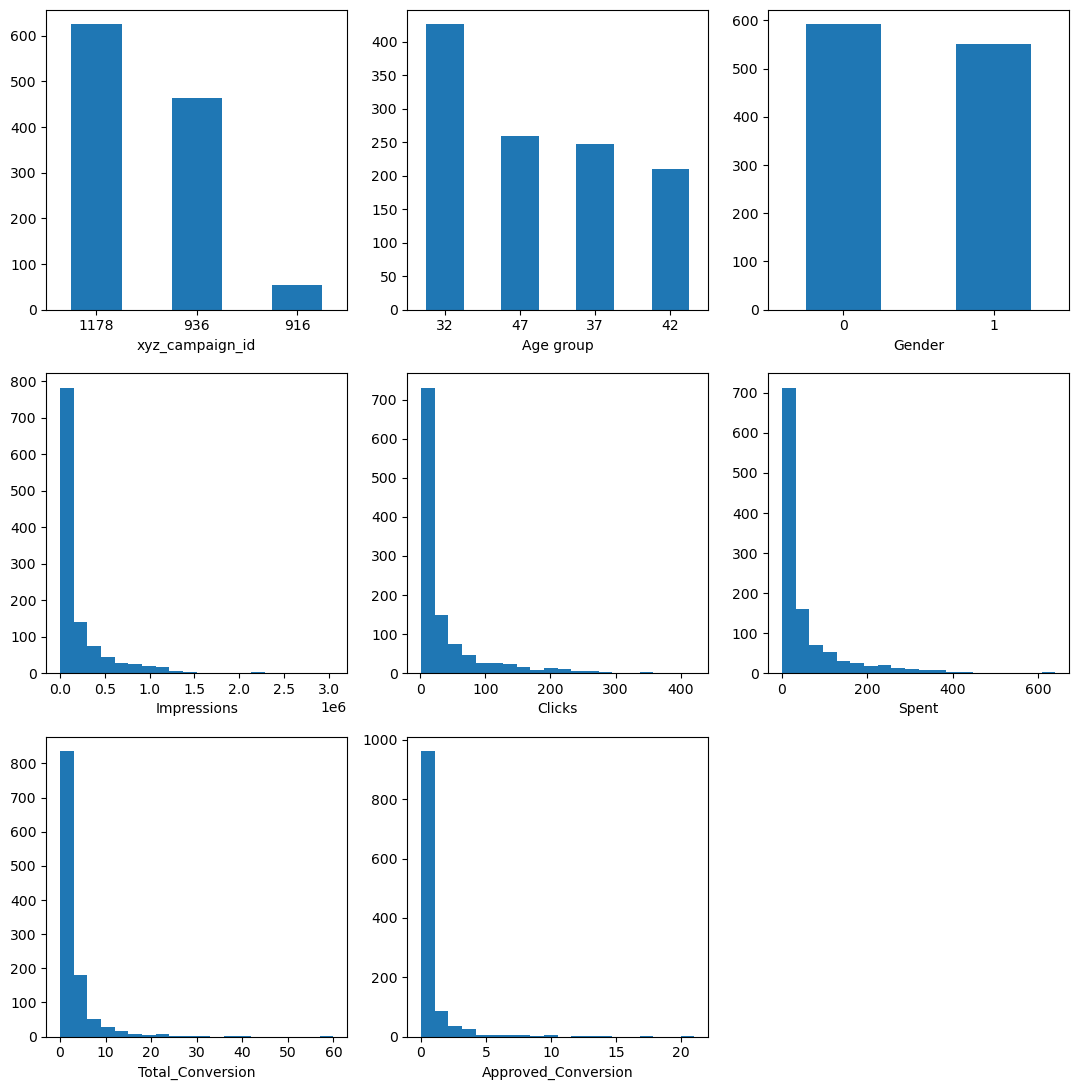

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(11,11))
df["xyz_campaign_id"].value_counts().plot(kind="bar", ax=ax[0, 0])
ax[0, 0].tick_params(labelrotation=0)
ax[0, 0].set_xlabel("xyz_campaign_id")

df["age"].value_counts().plot(kind="bar", ax=ax[0, 1])
ax[0, 1].tick_params(labelrotation=0)
ax[0, 1].set_xlabel("Age group")


df["gender"].value_counts().plot(kind="bar", ax=ax[0, 2])
ax[0, 2].tick_params(labelrotation=0)
ax[0, 2].set_xlabel("Gender")

df["Impressions"].hist(ax=ax[1, 0], bins=20)
ax[1, 0].grid(False)
ax[1, 0].set_xlabel("Impressions")

df["Clicks"].hist(ax=ax[1, 1], bins=20)
ax[1, 1].grid(False)
ax[1, 1].set_xlabel("Clicks")

df["Spent"].hist(ax=ax[1, 2], bins=20)
ax[1, 2].grid(False)
ax[1, 2].set_xlabel("Spent")

df["Total_Conversion"].hist(ax=ax[2, 0], bins=20)
ax[2, 0].grid(False)
ax[2, 0].set_xlabel("Total_Conversion")

df["Approved_Conversion"].hist(ax=ax[2, 1], bins=20)
ax[2, 1].grid(False)
ax[2, 1].set_xlabel("Approved_Conversion")

plt.tight_layout()
ax[2, 2].axis('off')

From above , we can make some quick observations:  
•	The campaign id 1178 and 936 are relatively more focused on by the company than 916. This is given by the number of times the ad campaigns appear, where 1178 and 936 shows up more than 400 times, while it is less than 100 times for 916.  
•	The most focused age group is 30-34, where the number of audiences in that age group is roughly 1.5 times that of other groups.  
•	The number of male and female users are roughly equal.  
•	The distribution of Impressions, Clicks, Spent, Total_Conversion and Approved_Conversion is significantly alike. One possible explanation for this is that the variables are strongly dependent, i.e. the higher the spending, the higher the impressions, clicks and thus the higher the conversion rate of users.  
In addition, we would also like to investigate the correlation between the features, which can help verify our explanation for the almost same distributions of some variables. This is because having the same distribution does not necessarily imply that the variables are highly correlated.


#### Multivariate Analysis: Correlation Heatmap

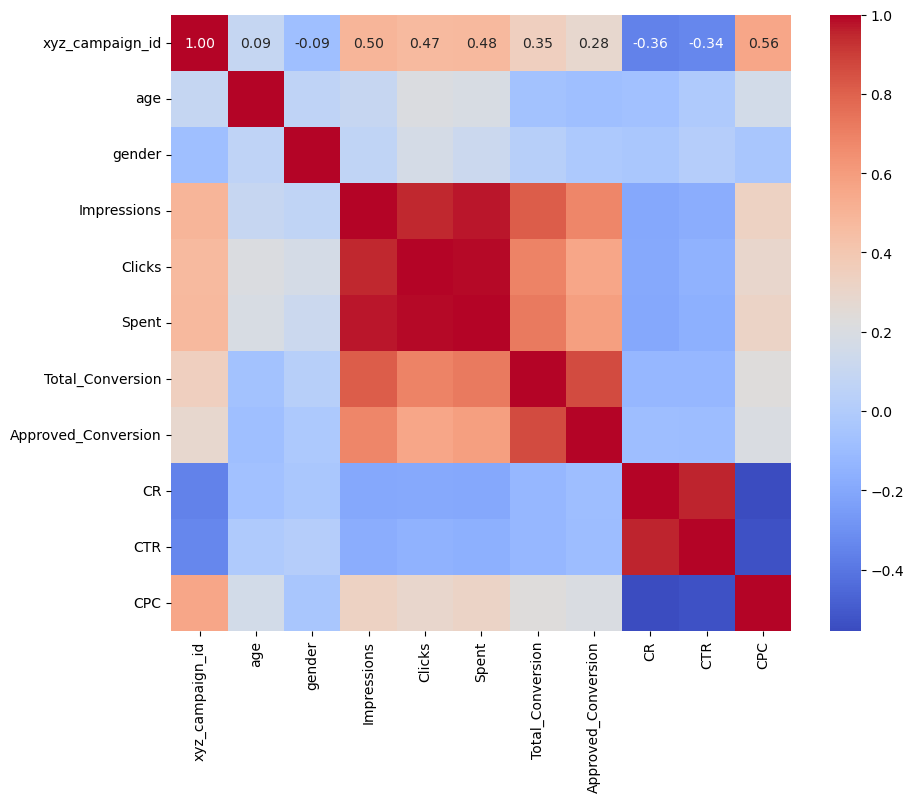

In [46]:

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

As expected, high correlation is presented within Impressions, Clicks and Spent, showing almost perfect linear dependence relationship, suggests that more engaging ads (those with higher CTR and CR) can lead to lower costs per click, which is beneficial for campaign efficiency. For the other features, the correlation coefficient is not as significant.

## A/B Testing

#### Campaign Analysis

First, we may plot the three ad campaign id on the same graph for each other variables for an overall overview and comparison of the campaigns' performance.

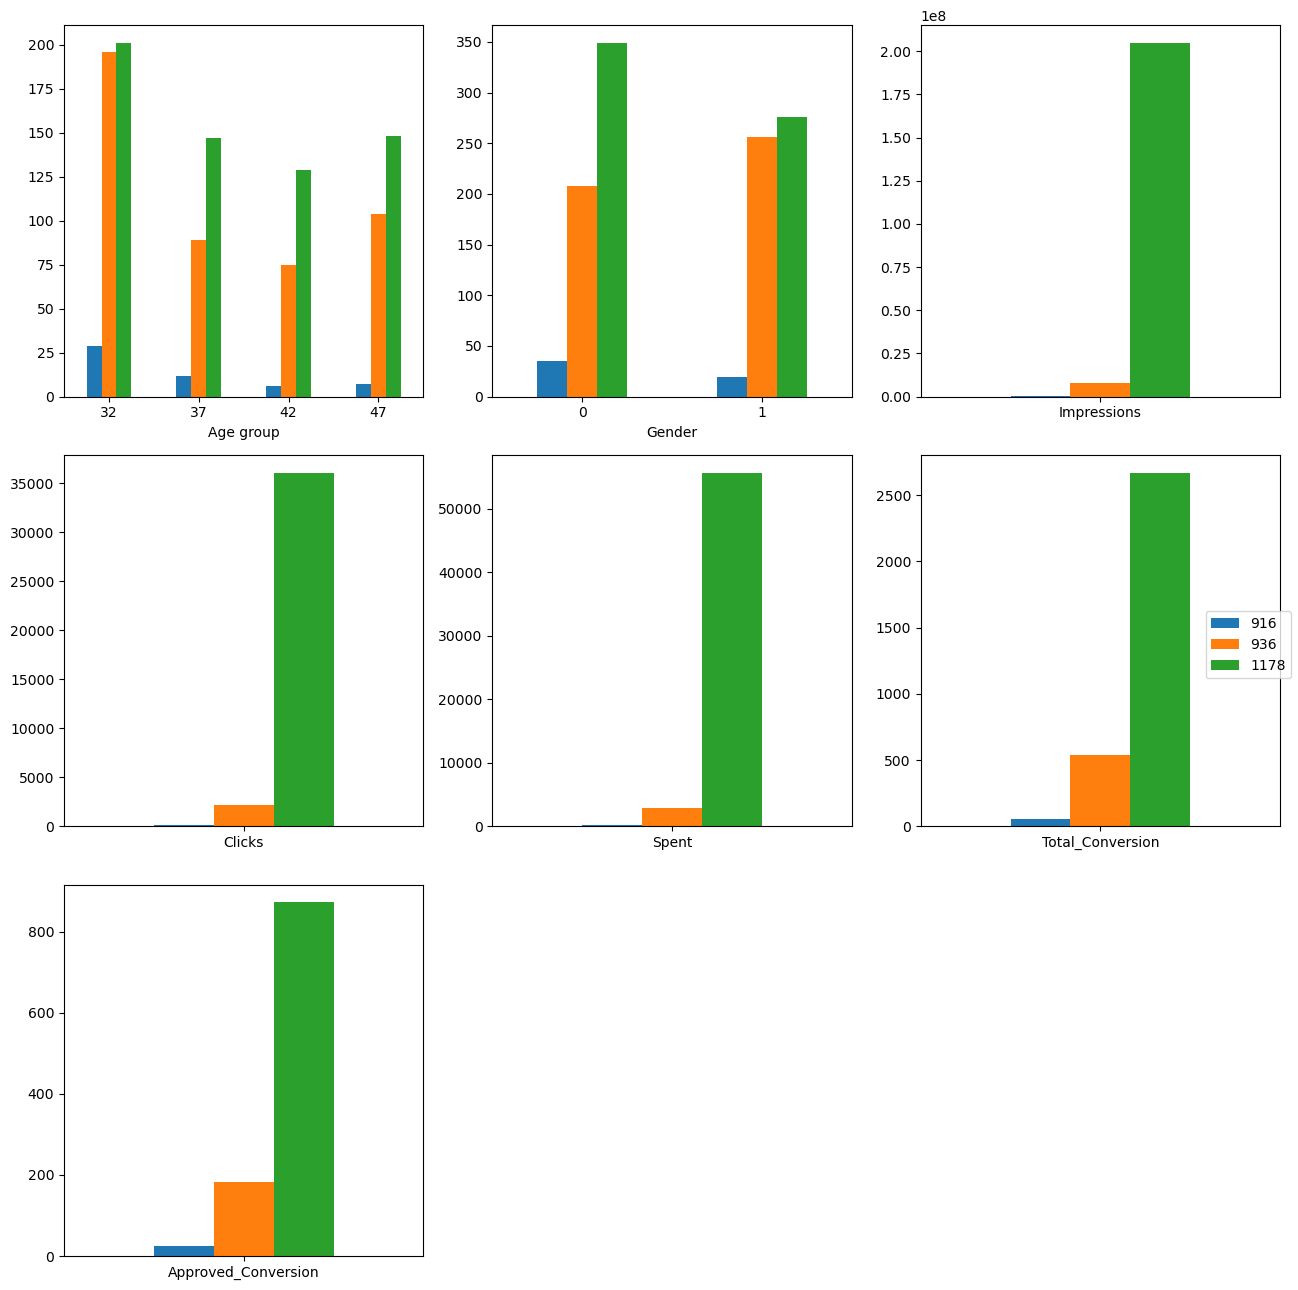

In [55]:
fig, ax = plt.subplots(3, 3, figsize=(13, 13))

# Plot Age group vs xyz_campaign_id
df[["age", "xyz_campaign_id"]].pivot_table(index="age", columns="xyz_campaign_id", aggfunc="size", fill_value=0).plot(kind="bar", ax=ax[0, 0], legend=None)
ax[0, 0].tick_params(labelrotation=0)
ax[0, 0].set_xlabel("Age group")

# Plot Gender vs xyz_campaign_id
df[["gender", "xyz_campaign_id"]].pivot_table(index="gender", columns="xyz_campaign_id", aggfunc="size", fill_value=0).plot(kind="bar", ax=ax[0, 1], legend=None)
ax[0, 1].tick_params(labelrotation=0)
ax[0, 1].set_xlabel("Gender")

# Plot Impressions by xyz_campaign_id
df[["xyz_campaign_id", "Impressions"]].pivot_table(columns="xyz_campaign_id", values="Impressions", aggfunc="sum").plot(kind="bar", ax=ax[0, 2], legend=None)
ax[0, 2].tick_params(labelrotation=0)

# Plot Clicks by xyz_campaign_id
df[["xyz_campaign_id", "Clicks"]].pivot_table(columns="xyz_campaign_id", values="Clicks", aggfunc="sum").plot(kind="bar", ax=ax[1, 0], legend=None)
ax[1, 0].tick_params(labelrotation=0)

# Plot Spent by xyz_campaign_id
df[["xyz_campaign_id", "Spent"]].pivot_table(columns="xyz_campaign_id", values="Spent", aggfunc="sum").plot(kind="bar", ax=ax[1, 1], legend=None)
ax[1, 1].tick_params(labelrotation=0)

# Plot Total Conversion by xyz_campaign_id
df[["xyz_campaign_id", "Total_Conversion"]].pivot_table(columns="xyz_campaign_id", values="Total_Conversion", aggfunc="sum").plot(kind="bar", ax=ax[1, 2], legend=None)
ax[1, 2].tick_params(labelrotation=0)

# Plot Approved Conversion by xyz_campaign_id
df[["xyz_campaign_id", "Approved_Conversion"]].pivot_table(columns="xyz_campaign_id", values="Approved_Conversion", aggfunc="sum").plot(kind="bar", ax=ax[2, 0], legend=None)
ax[2, 0].tick_params(labelrotation=0)

# Disable unused subplots
ax[2, 1].axis('off')
ax[2, 2].axis('off')

# Add a legend to the right of the plots
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

plt.tight_layout()
plt.show()


Based on the bar plots, we can make some general observations:

•	All three campaigns primarily target the 30-34 age group. Campaign 936 has a mostly female audience, while the other two campaigns have more male audiences.  
•	Campaign 1178 dominates the other two campaigns in terms of investment (spent), impressions, clicks and conversion. This is expected, as we earlier have shown that these variables are strongly dependent on each other with higher campaign budget comes higher audience reach and thus higher clicks and conversion.  
It is clear to recognize that campaign 1178 outperforms its counterparts by showing notably higher interactions and conversion. However, as we recall, this is a highly possible result of the significantly larger spending allocated for campaign 1178 by the company (over 45000 USD than 936, and over 50000 USD than 916); and we cannot know whether the other campaigns would obtain the same, or even better results if they were invested the same amount. Therefore, it would not be reasonable to rush to the conclusion that 1178 has better efficiency.

In order to gain a better assessment of the campaigns' true performance, we must look into the KPIs CR, CPC and CTR chosen above. To briefly describe, CR (conversion rate) reflects the conversion ability for each campaign, CPC (cost per click) measures the cost efficiency for each click the ad set recieve, and CTR (click through rate) shows the ability to attract and engage customers. Because the three metrics are measured as ratio, they can allow more robust and more accurate comparison between ad campaigns even with large differences in spending.

Let us visualize the means of the KPIs for all the ad sets belong from each of the three ad campaigns:

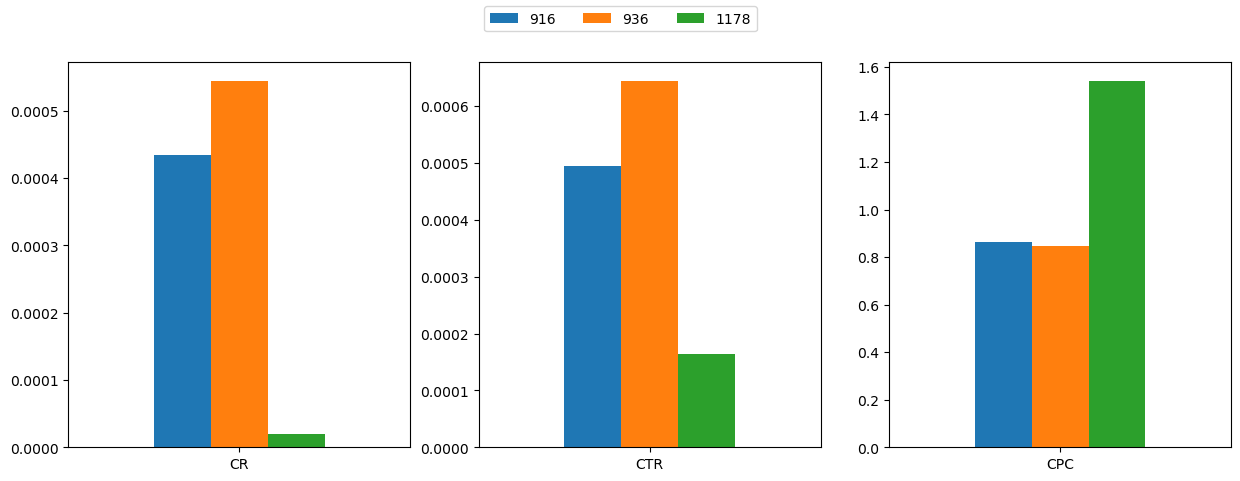

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df[["xyz_campaign_id", "CR"]].pivot_table(columns="xyz_campaign_id", values="CR", aggfunc="mean").plot(kind="bar", ax=ax[0], legend=None)
ax[0].tick_params(labelrotation=0)

df[["xyz_campaign_id", "CTR"]].pivot_table(columns="xyz_campaign_id", values="CTR", aggfunc="mean").plot(kind="bar", ax=ax[1], legend=None)
ax[1].tick_params(labelrotation=0)

df[["xyz_campaign_id", "CPC"]].pivot_table(columns="xyz_campaign_id", values="CPC", aggfunc="mean").plot(kind="bar", ax=ax[2], legend=None)
ax[2].tick_params(labelrotation=0)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)


Campaign Dominance and Investment:  
Campaign 1178 dominates in Impressions, Clicks, and Conversions, indicating a high budget and wide reach.
Campaign 936 has a high Conversion Rate (CR) and lower CPC, suggesting better cost efficiency.
Campaign 916 has the lowest metrics but the lowest CPC, making it the most cost-effective despite limited reach.

Cost Efficiency and Targeting:  
Campaign 1178 has a higher CPC and lower CTR, indicating it may not be targeting the most engaged audience despite its broad reach.
Campaign 936 balances reach and efficiency well, with a high CR and lower CPC than Campaign 1178.

Budget and Performance Correlation:  
Campaign 1178's strong metrics are likely driven by its higher spending, but this doesn’t necessarily mean better efficiency.
It's unclear if Campaign 936 or Campaign 916 would perform as well with the same budget, so efficiency comparisons based on current spending may be misleading.

    In summary, From the KPIs, campaign 1178 is not at all cost-efficient with the highest CPC, while generate much lower CR and CTR than its counterparts. On the other hand, 936 and 916 has proven to perform better in terms of conversion, engagement and cost-efficiency, with higher CTR, CR while remain lower in CPC. In the previous analysis, though we have observed a significant greater number of clicks, impressions and conversions from 1178, it is now clear that seems to be explained by the higher allocated budget.

#### A/B testing for multiple pairwise comparisions  

Purpose: The main goal of A/B testing here is to determine whether the observed differences between the ad campaigns (in terms of metrics like Conversion Rate, Click-Through Rate, and Cost Per Click) are statistically significant or simply due to chance.  

Multiple Comparisons Problem: Since we are making multiple pairwise comparisons (Campaign 916 vs. 936, 916 vs. 1178, 936 vs. 1178), there's a risk of increasing the likelihood of a Type I error (false positive). To address this, we can use the post-hoc method Bonferroni correction, to make the rejected significance threshold more strict to compensate for the number of inferences being made.

The detailed steps can be given by:

1. Residuals normality check of groups using Shapiro-Wilk test.  
    a) If normal, check for variance homogenity of groups using Levene's test.  
        If homogenous, perform pair-wise T-test.  
        If not homogenous, perform pair-wise Welch's test.  
    b) If not normal, perform pair-wise Mann Whitney U test.  
2. Apply Boferroni correction to conclude the test.  

Bonferroni Correction:  
For the significance level, we can use the standard α = 0.05 significance level. To perform Bonferroni correction, we simply lower the significance level by dividing thr current α = 0.05 to the number of pairwise comparisons, which is equal to 3 here. The adjusted significance threshold is: α/3 = 0.05/3 ≈ 0.0167

Now, each individual test must achieve a p-value below 0.0167 to be considered statistically significant, reducing the overall chance of making a Type I error across all tests.

##### Residuals Normality Check with the Shapiro-Wilk Test

Null hypothesis (H0): The distribution of the sample are close to normal.

Alternate hypothesis (H1): The distribution of the sample are not close to normal.

In [62]:
# For Conversion rate:

_, pvalue1 = shapiro(df.loc[df["xyz_campaign_id"] == 916, "CR"])
_, pvalue2 = shapiro(df.loc[df["xyz_campaign_id"] == 936, "CR"])
_, pvalue3 = shapiro(df.loc[df["xyz_campaign_id"] == 1178, "CR"])

print("p-value for group A: ", pvalue1)
print("p-value for group B: ", pvalue2)
print("p-value for group C: ", pvalue3)

p-value for group A:  5.963321503266172e-10
p-value for group B:  4.150259129730709e-34
p-value for group C:  1.2178525550701994e-33


In [63]:
# For Click through rate:

_, pvalue1 = shapiro(df.loc[df["xyz_campaign_id"] == 916, "CTR"])
_, pvalue2 = shapiro(df.loc[df["xyz_campaign_id"] == 936, "CTR"])
_, pvalue3 = shapiro(df.loc[df["xyz_campaign_id"] == 1178, "CTR"])

print("p-value for group A: ", pvalue1)
print("p-value for group B: ", pvalue2)
print("p-value for group C: ", pvalue3)

p-value for group A:  8.429466846759937e-11
p-value for group B:  5.090885117483896e-34
p-value for group C:  1.227071879839059e-05


In [64]:
# for Cost per conversion

_, pvalue1 = shapiro(df.loc[df["xyz_campaign_id"] == 916, "CPC"])
_, pvalue2 = shapiro(df.loc[df["xyz_campaign_id"] == 936, "CPC"])
_, pvalue3 = shapiro(df.loc[df["xyz_campaign_id"] == 1178, "CPC"])

print("p-value for group A: ", pvalue1)
print("p-value for group B: ", pvalue2)
print("p-value for group C: ", pvalue3)

p-value for group A:  7.768616683279106e-08
p-value for group B:  2.5887991134222316e-24
p-value for group C:  1.3052494139468444e-31


Because all three groups yield p-values much lower than 0.05, there is strong evidence against the Null hypothesis, and the groups' residuals are not normal.  
Given that the data does not follow a normal distribution, we cannot proceed with parametric tests like the t-test, which assume normality. Instead, we must use a non-parametric test that does not require the normality assumption.  
Since all three groups of all three KPIs fail to satisfy the normality condition, we can use the non-parametric Mann Whitney U test.

#### Mann-Whitney U Test

This non-parametric test compares the ranks of values in two independent groups to determine if there is a difference in their central tendencies (like medians).

Null Hypothesis (H0): There is no difference in the central tendencies between the two groups.  
Alternative Hypothesis (H1): There is a difference in the central tendencies between the two groups.

In [65]:
# For Conversion rate:
_, pvalue1 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 916, "CR"], df.loc[df["xyz_campaign_id"] == 936, "CR"])
_, pvalue2 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 936, "CR"], df.loc[df["xyz_campaign_id"] == 1178, "CR"])
_, pvalue3 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 1178, "CR"], df.loc[df["xyz_campaign_id"] == 916, "CR"])

print("p-value for 916-936: ", pvalue1)
print("p-value for 936-1178: ", pvalue2)
print("p-value for 1178-916: ", pvalue3)

p-value for 916-936:  0.4339652264015792
p-value for 936-1178:  1.7577705732449588e-133
p-value for 1178-916:  6.636971249222305e-31


In [66]:
# For Click through rate:
_, pvalue1 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 916, "CTR"], df.loc[df["xyz_campaign_id"] == 936, "CTR"])
_, pvalue2 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 936, "CTR"], df.loc[df["xyz_campaign_id"] == 1178, "CTR"])
_, pvalue3 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 1178, "CTR"], df.loc[df["xyz_campaign_id"] == 916, "CTR"])

print("p-value for 916-936: ", pvalue1)
print("p-value for 936-1178: ", pvalue2)
print("p-value for 1178-916: ", pvalue3)

p-value for 916-936:  0.953272496172231
p-value for 936-1178:  5.773236981710117e-95
p-value for 1178-916:  8.021835868757632e-20


In [67]:
# For Cost per click:
_, pvalue1 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 916, "CPC"], df.loc[df["xyz_campaign_id"] == 936, "CPC"])
_, pvalue2 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 936, "CPC"], df.loc[df["xyz_campaign_id"] == 1178, "CPC"])
_, pvalue3 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 1178, "CPC"], df.loc[df["xyz_campaign_id"] == 916, "CPC"])

print("p-value for 916-936: ", pvalue1)
print("p-value for 936-1178: ", pvalue2)
print("p-value for 1178-916: ", pvalue3)

p-value for 916-936:  0.7970274733773802
p-value for 936-1178:  3.206787240273559e-76
p-value for 1178-916:  1.9701792542537628e-18


For Conversion Rate: Significant differences are observed between campaigns 936-1178 and 1178-916, but not between 916-936.  
For Click-Through Rate: Significant differences are observed between campaigns 936-1178 and 1178-916, but not between 916-936.  
For Cost Per Click: Significant differences are observed between campaigns 936-1178 and 1178-916, but not between 916-936.  

In all three cases, compared to the adjusted significance level 0.01667, we do not reject the Null hypohesis for 916-936, but reject for 936-1178 and 1178-916. This suggests that the difference in CR, CTR and CPC between 936-1178 and 1178-916 is statistically significant and should be considered, while the difference of the KPIs between 916-936 is only due to chance.

## Conclusion

### Summary of Key Insights

1. **Campaign 936 and 916 Performance**:
   - **Conversion Rate (CR)**: Campaigns 936 and 916 demonstrated significantly higher conversion rates compared to Campaign 1178. This indicates that these two campaigns are more effective in turning impressions into conversions.
   - **Click-Through Rate (CTR)**: Both 936 and 916 also showed superior click-through rates, suggesting they were more engaging and successful in capturing user interest compared to Campaign 1178.
   - **Cost-Per-Click (CPC)**: The cost-efficiency of Campaigns 936 and 916 was better, as they managed to achieve higher conversions and clicks at a lower cost compared to Campaign 1178.

2. **Campaign 1178 Performance**:
   - **Efficiency Concerns**: Despite a higher budget allocation, Campaign 1178 underperformed in terms of conversion rate and engagement (CTR) relative to its cost. This suggests that the additional spending did not translate into proportional performance improvements.

3. **Target Audience Insights**:
   - **Age Group 30-34**: The most engaged demographic was identified as the 30-34 age group. This suggests that this segment is the most responsive to the company’s ad campaigns.

### Business Recommendations

1. **Prioritize Scaling Campaigns 936 and 916**:
   - **Optimize Budget Allocation**: Given their strong performance, increasing the budget for Campaigns 936 and 916 could yield higher returns. However, scaling should be done cautiously, monitoring how the campaigns perform with a broader audience.
   - **Focus on High-Performing Strategies**: Analyze what elements of these campaigns contribute to their success (e.g., creative content, targeting strategy) and replicate these elements in future campaigns.

2. **Reevaluate Campaign 1178**:
   - **Investigate Inefficiencies**: Conduct a detailed review of Campaign 1178 to identify why it underperformed despite higher spending. Factors to consider could include targeting accuracy, ad content, or channel effectiveness.
   - **Consider Redistribution of Budget**: If the inefficiencies are not easily correctable, consider reallocating part of the budget from Campaign 1178 to more effective campaigns like 936 and 916.

3. **Targeting Strategy Refinement**:
   - **Age Group 30-34**: Since this group showed the highest engagement, tailor future campaigns to further appeal to this demographic. Consider using more personalized content or offers that resonate with this age group.
   - **Expand Audience Insights**: Beyond the 30-34 age group, investigate why other age groups are less responsive. Adjust targeting strategies to either better reach these segments or refine messaging to enhance engagement.

4. **Experiment with Ad Variants**:
   - **A/B Testing for Optimization**: Continue conducting A/B testing on different aspects of the campaigns (e.g., ad copy, imagery, CTA) to refine and optimize performance further.
   - **Test Different Channels**: Explore the effectiveness of different ad platforms or channels, especially for Campaign 1178, to identify more efficient avenues for reaching the target audience.
